In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import collections

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from scikitplot.estimators import plot_feature_importances, plot_learning_curve

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import xgbfir

%matplotlib inline

In [2]:
def check_missing(data):
    for column in data.columns:
        missing = column, data[column].isnull().sum()
        if missing[1] == 0: continue
        print(missing)

def convert_list_lowercase(data):
    return [x.lower().strip() for x in data]

def convert_object_lowercase(value):
    return str(value).lower().strip()

def get_feats(df, black_list=['price', 'price_log', 'id']):
    num_feats = df.select_dtypes(np.number).columns
    return [x for x in num_feats if x not in black_list]

def summary(values, percentiles=[1, 5, 95, 99, 100]):
    for percentile in percentiles:
        print('{0}th -> {1}'.format(percentile, np.percentile(values, percentile) ))

In [3]:
def ln_cosh_obj(predt: np.ndarray, dtrain: xgb.DMatrix):
    labels = dtrain.get_label()
    grad = np.tanh(preds - labels)
    hess = 1 - grad*grad
    return grad, hess

def ln_cosh_obj_scorer(predt, dtrain):
    labels = dtrain.get_label()
    grad = np.tanh(preds - labels)
    hess = 1 - grad*grad
    return grad, hess

def my_scorer(model, X, y):
    y_pred = model.predict(X)
    y = np.exp(y)
    y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    return mean_absolute_error(y, y_pred)

def calculate_error(y_test, y_pred):
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    return mean_absolute_error(y_test, y_pred)

In [4]:
train = pd.read_hdf('property.train.h5')
test = pd.read_hdf('property.test.h5') 
df_all = pd.concat([train, test], axis=0)
print("train & test: ", train.shape, test.shape)

train & test:  (45694, 35) (22667, 35)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45694 entries, 0 to 45693
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   breadcrumbs                 45694 non-null  object 
 1   date                        45694 non-null  object 
 2   geo_block                   45694 non-null  object 
 3   owner                       45694 non-null  object 
 4   price                       45694 non-null  float64
 5   Security:                   26186 non-null  object 
 6   Building type:              45520 non-null  object 
 7   Object type:                45686 non-null  object 
 8   Ad type:                    45686 non-null  object 
 9   Commission agent:           45371 non-null  object 
 10  Construction phase:         35768 non-null  object 
 11  Housing class:              35768 non-null  object 
 12  Elevator:                   26821 non-null  object 
 13  Bathroom type:              123

In [6]:
factorize_feats = [f for f in df_all.columns if ":" in f]
for feat in factorize_feats:
    df_all["{}_cat".format(feat)] = df_all[feat].factorize()[0]
    

print("extract geo_block")    
def extract_geoblock(vals):
    vals = vals[: int(len(vals) / 2)]
    return {"geo_block_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

df_geo_block = df_all["geo_block"].map(extract_geoblock).apply(pd.Series)
df_all = pd.concat([df_all, df_geo_block], axis=1)

feats_geo_block = [ x for x in df_geo_block.columns]
for f in feats_geo_block:
    df_all["{}_cat".format(f)] = df_all[f].factorize()[0]

extract geo_block


In [7]:
print("extract breadcrumbs")    
def extract_breadcrumbs(vals):
    vals = vals[1:]
    return {"breadcrumbs_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

df_breadcrumbs = df_all["breadcrumbs"].map(extract_breadcrumbs).apply(pd.Series)
df_all = pd.concat([df_all, df_breadcrumbs], axis=1)

feats_breadcrumbs = [ x for x in df_breadcrumbs.columns]
for f in feats_breadcrumbs:
    df_all["{}_cat".format(f)] = df_all[f].factorize()[0]

extract breadcrumbs


In [8]:
print("extract owner") 
def extract_owner(vals):
    return {"owner_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

df_owner = df_all["owner"].map(extract_owner).apply(pd.Series)
df_all = pd.concat([df_all, df_owner], axis=1)

feats_owner = [ x for x in df_owner.columns]
for f in feats_owner:
    df_all["{}_cat".format(f)] = df_all[f].factorize()[0]

extract owner


In [9]:
def get_total_views(date):
    return int(date[1])

def get_views_today(date):
    if len(date) > 2 and date[2].startswith('('):
        return int(date[2][2:4].strip())
    return 0

months_map = {
    'января': 1,
    'февраля': 2,
    'марта': 3,
    'апреля': 4,
    'мая': 5,
    'июня': 6,
    'июля': 7,
    'августа': 8,
    'сентября': 9,
    'октября': 10,
    'ноября': 11,
    'декабря': 12
}

def get_updated_this_year(dates):
    if len(dates) > 2:
        if 'обновлено' in dates[2]:
            return 1
    if len(dates) > 3:
        return 1
    return 0

def get_year_added(dates):
    if dates[0][-4:].isdigit():
        return int(dates[0][-4:])
    return 2019

def get_month_added(dates):
    date = dates[0].split()
    if date[0].isdigit():
        return months_map[date[1]]
    return 0

df_all['views_total_cat'] = df_all['date'].map(get_total_views)
# df_all['views_today_cat'] = df_all['date'].map(get_views_today)
df_all['year_added_cat'] = df_all['date'].map(get_year_added)
df_all['updated_this_year_cat'] = df_all['date'].map(get_updated_this_year)
# df_all['month_added_cat'] = df_all['date'].map(get_month_added)

In [10]:
feats = [x for x in df_all.columns if "_cat" in x]
print("feats: ", feats)

df_train, df_test = df_all[ False ==  df_all["price"].isnull() ], df_all[ df_all["price"].isnull() ]
# df_2 = df_train.copy()
# df_2 = df_2[df_2['price'] <= np.percentile(df_train['price'], 99)]
# df_train = df_train[df_train['price'] <= np.percentile(df_train['price'], 99)]

X_train, X_test = df_train[feats].values, df_test[feats].values
y_train = df_train["price"].values
y_log_tain = np.log(y_train)

print("train model")
model = xgb.XGBRegressor(n_estimators=70, learning_rate=0.2, max_depth=10, random_state=0, obj=ln_cosh_obj, eval_metric='mae')
model.fit(X_train, y_log_tain)

print("predict")
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

print("save file")
test['price'] = y_pred
test[['id', 'price']].to_csv('model_dummy.csv', index=False) 

feats:  ['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'geo_block_0_cat', 'geo_block_1_cat', 'geo_block_2_cat', 'geo_block_3_cat', 'geo_block_4_cat', 'geo_block_5_cat', 'breadcrumbs_0_cat', 'breadcrumbs_1_cat', 'breadcrumbs_2_cat', 'breadcrumbs_3_cat', 'breadcrumbs_4_cat', 'breadcrumbs_5_cat', 'breadcrumbs_6_cat', 'owner_0_cat', 'views_total_cat', 'year_added_cat', 'updated_this_year_cat']
train model
predict
s

D:\venv\pml8\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


mean=5.212024, std=0.320917, scores=[5.04926588 4.82044527 5.1967164  5.20305021 5.79064232]
Wall time: 8.79 s


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

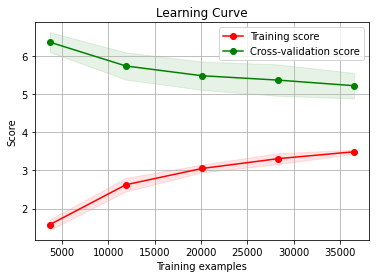

In [11]:
scores = cross_val_score(model, X_train, y_log_tain, cv=5, scoring=my_scorer)
print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 6), np.round(np.std(scores), 6), scores))
%time plot_learning_curve(model, X_train, y_log_tain, cv=5, random_state=0, n_jobs=8, shuffle=True, scoring=my_scorer);

In [12]:
model = xgb.XGBRegressor(n_estimators=70, learning_rate=0.2, max_depth=10, random_state=0, obj=ln_cosh_obj, eval_metric='mae')
model.fit(X_train, y_log_tain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=70, n_jobs=32, num_parallel_tree=1,
             obj=<function ln_cosh_obj at 0x0000021CEF073820>, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

mean=5.212024, std=0.320917, scores=[5.04926588 4.82044527 5.1967164  5.20305021 5.79064232]
Wall time: 7.49 s


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

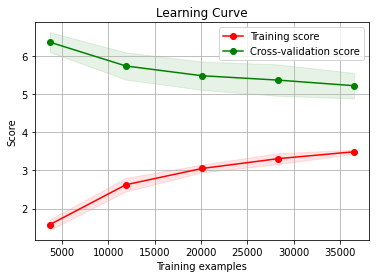

In [13]:
scores = cross_val_score(model, X_train, y_log_tain, cv=5, scoring=my_scorer)
print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 6), np.round(np.std(scores), 6), scores))
%time plot_learning_curve(model, X_train, y_log_tain, cv=5, random_state=0, n_jobs=8, shuffle=True, scoring=my_scorer);

In [14]:
model.get_booster().feature_names = feats
importance_weight = model.get_booster().get_score(importance_type='weight')
importance_gain = model.get_booster().get_score(importance_type='gain')
importance_cover = model.get_booster().get_score(importance_type='cover')

sorted_importance_weight = collections.OrderedDict({k: v for k, v in reversed(sorted(importance_weight.items(), key=lambda item: item[1]))})
sorted_importance_gain = collections.OrderedDict({k: v for k, v in reversed(sorted(importance_gain.items(), key=lambda item: item[1]))})
sorted_importance_cover = collections.OrderedDict({k: v for k, v in reversed(sorted(importance_cover.items(), key=lambda item: item[1]))})

In [15]:
# important_columns = list(sorted_importance_gain.keys())
# len(important_columns)

In [16]:
xgbfir.saveXgbFI(model, feature_names=feats, OutputXlsxFile='bost_fi.xlsx')

In [17]:
interaction_0 = pd.read_excel('bost_fi.xlsx', 'Interaction Depth 0')
interaction_0_list = list(interaction_0['Interaction'])
interaction_0

<ipython-input-17-350497ffd715>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  interaction_0 = pd.read_excel('bost_fi.xlsx', 'Interaction Depth 0')


,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,Construction phase:_cat,11376.187914,730,22.291089,0.030536,15.583819,915.529865,1,10,13,21,3,4,8.666667,29.853425,7.060274
1,Building type:_cat,9686.328490,1550,40.113779,0.025880,6.249244,8592.397692,2,5,7,24,4,1,7.166667,37.684516,7.474839
2,Housing class:_cat,8829.118234,510,26.130783,0.051237,17.311997,3225.609412,3,14,10,11,2,2,7.000000,30.423529,6.850980
3,breadcrumbs_0_cat,4627.228965,1621,100.367291,0.061917,2.854552,310.273808,4,3,1,8,6,7,4.833333,29.604565,7.029611
4,geo_block_0_cat,3611.865174,124,13.586160,0.109566,29.127945,3017.573312,5,25,17,5,1,3,9.333333,27.927419,6.927419
5,breadcrumbs_1_cat,2224.148618,1343,67.019499,0.049903,1.656105,236.431280,6,6,2,12,11,9,7.666667,30.689501,7.184661
6,Security:_cat,2139.544082,2231,42.462380,0.019033,0.959007,87.990061,7,2,5,30,19,11,12.333333,33.073510,7.382340
7,Object type:_cat,2121.220835,718,23.138202,0.032226,2.954347,296.093170,8,11,12,17,5,8,10.166667,31.225627,7.292479
8,views_total_cat,1953.471599,6211,60.833020,0.009794,0.314518,79.606742,9,1,3,40,35,12,16.666667,36.588794,7.613106
9,geo_block_1_cat,1694.472178,1552,48.368560,0.031165,1.091799,73.512752,10,4,4,20,17,14,11.500000,30.641753,7.322165


In [18]:
interaction_1 = pd.read_excel('bost_fi.xlsx', 'Interaction Depth 1')
interaction_1_list = list(interaction_1['Interaction'])
interaction_1

<ipython-input-18-d9cad76513dd>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  interaction_1 = pd.read_excel('bost_fi.xlsx', 'Interaction Depth 1')


,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,Construction phase:_cat|Housing class:_cat,15737.079997,61,3.924016,0.064328,257.984918,1359.303781,1,66,32,18,2,4,20.500000,20.426230,5.508197
1,Building type:_cat|geo_block_0_cat,15674.005928,26,12.331400,0.474285,602.846382,12787.351846,2,88,7,1,1,1,16.666667,23.076923,4.269231
2,Building type:_cat|Housing class:_cat,15075.273016,60,6.874097,0.114568,251.254550,4379.626766,3,68,14,7,4,2,16.333333,26.266667,5.566667
3,Housing class:_cat|breadcrumbs_0_cat,6434.522262,126,5.992844,0.047562,51.067637,754.201770,4,38,17,29,11,5,17.333333,28.912698,6.619048
4,Housing class:_cat|Housing class:_cat,5289.694942,21,4.878562,0.232312,251.890235,2428.702243,5,91,26,2,3,3,21.666667,19.761905,6.476190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Ad type:_cat|views_total_cat,167.087611,200,1.757889,0.008789,0.835438,4.731355,96,25,64,89,94,82,75.000000,32.930000,7.850000
96,geo_block_2_cat|geo_block_2_cat,164.544808,73,2.364687,0.032393,2.254038,2.777581,97,58,57,44,79,95,71.666667,34.506849,6.712329
97,Balcony type:_cat|views_total_cat,163.473782,362,0.927759,0.002563,0.451585,1.351853,98,8,85,99,99,100,81.500000,32.798343,7.792818
98,Bathroom type:_cat|Mortgage possible:_cat,159.530414,15,1.022585,0.068172,10.635361,8.187424,99,96,82,14,35,73,66.500000,24.466667,6.533333


In [19]:
interaction_2 = pd.read_excel('bost_fi.xlsx', 'Interaction Depth 2')
interaction_2_list = list(interaction_2['Interaction'])
interaction_2

<ipython-input-19-49424116359d>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  interaction_2 = pd.read_excel('bost_fi.xlsx', 'Interaction Depth 2')


,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,Building type:_cat|Construction phase:_cat|Hou...,24758.471164,27,2.900381,0.107422,916.980413,2012.154933,1,32,13,19,8,4,12.833333,11.814815,3.703704
1,Building type:_cat|Building type:_cat|geo_bloc...,11516.656333,6,3.616755,0.602792,1919.442722,8330.195171,2,76,8,3,2,1,15.333333,6.833333,3.166667
2,Building type:_cat|Housing class:_cat|breadcru...,11172.818009,26,1.012518,0.038943,429.723770,879.863315,3,35,35,45,22,9,24.833333,25.346154,4.730769
3,Building type:_cat|geo_block_0_cat|views_total...,10426.977485,13,0.994857,0.076527,802.075191,1462.460824,4,56,38,28,10,5,23.500000,22.923077,4.461538
4,Construction phase:_cat|breadcrumbs_1_cat|brea...,9204.332061,16,0.723902,0.045244,575.270754,415.356761,5,50,50,41,15,17,29.666667,8.375000,6.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Bathroom type:_cat|Object type:_cat|breadcrumb...,439.313067,15,3.389110,0.225941,29.287538,84.084295,96,54,9,10,74,37,46.666667,13.200000,5.200000
96,Ad type:_cat|Construction phase:_cat|Security:...,432.771857,17,0.095133,0.005596,25.457168,3.702660,97,49,85,91,77,95,82.333333,25.058824,6.764706
97,Ad type:_cat|Security:_cat|The view from the w...,429.855049,7,0.117171,0.016739,61.407864,15.485126,98,75,81,72,59,75,76.666667,21.714286,7.857143
98,Housing class:_cat|Housing class:_cat|updated_...,424.116882,2,0.409857,0.204928,212.058441,87.978303,99,98,66,11,29,34,56.166667,7.000000,5.500000


In [20]:
df_all['Building type:'].unique()

array(['Brick', 'Monolithic-brick', 'Monolithic', 'Panel', 'Block', nan,
       'Wooden', 'Panel-brick', 'Cast stone', 'Stalinist'], dtype=object)

In [21]:
df_all['Construction phase:'].unique()

array(['Commissioned', 'Building walls', 'Finish', nan, 'Playground',
       'Pit', 'Project', 'Is GK'], dtype=object)

In [22]:
df_all['Housing class:'].unique()

array(['Elite class', 'Comfort class', nan, 'Business class',
       'Economy class'], dtype=object)

In [23]:
np.average(df_all[(df_all['price'] > 0) & (df_all['Building type:'] == 'Brick') & (df_all['Housing class:'] == 'Elite class')]['price'])

123.2371563483146

In [24]:
interaction_set = set(interaction_0_list)
for i in interaction_1_list:
    split = i.split('|')
    for s in split:
        interaction_set.add(s)

for i in interaction_2_list:
    split = i.split('|')
    for s in split:
        interaction_set.add(s)

features_strong_interactions = list(interaction_set)
len(features_strong_interactions)

46

In [25]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_log_tain, test_size=0.3, random_state=0)

In [26]:
def objective(space):
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': 0.2,
        'random_state': 0,
        'n_estimators': int(space['n_estimators']),
        'obj': ln_cosh_obj,
        'eval_metric': 'mae'
    }
    
#     xgb_params = {
#         'max_depth': int(space['max_depth']),
#         'colsample_bytree': space['colsample_bytree'],
#         'learning_rate': space['learning_rate'],
#         'learning_rate': 0.2,
#         'subsample': space['subsample'],
#         'random_state': 0,
#         'min_child_weight': int(space['min_child_weight']),
#         'reg_alpha': space['reg_alpha'],
#         'reg_lambda': space['reg_lambda'],
#         'n_estimators': int(space['reg_n_estimators']),
#         'obj': ln_cosh_obj,
#         'eval_metric': 'mae'
#     }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train2, y_train2)
    y_pred = model.predict(X_test2)
    
    score = calculate_error(y_test2, y_pred)
    print(r2_score(y_test2, y_pred))
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'n_estimators': hp.quniform ('x_reg_n_estimators', 50, 1000, 1),
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

0.8154980239612448                                                                                                     
0.826181861252716                                                                                                      
0.8248413332927875                                                                                                     
0.7905280155023907                                                                                                     
0.7976173429350487                                                                                                     
0.7962046628401203                                                                                                     
0.7908187285832722                                                                                                     
0.7929149497218415                                                                                                     
0.8237288204359892                      

In [27]:
best_trial = trials.best_trial['misc']['vals']
best_trial

{'x_max_depth': [7.0], 'x_reg_n_estimators': [290.0]}

In [28]:
def run_cv_model(model_cls, model_params, X, y, cv=5, scoring=my_scorer, plot_l_curve=True):
    scores = []
    cv = KFold(n_splits=cv, random_state=0, shuffle=True)
    for train_idx, test_idx in cv.split(y):
        model = model_cls(**model_params)
        %time model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        score = calculate_error(y[test_idx], y_pred)
        scores.append(score)
        r2_score(y[test_idx], y_pred)

    print('mean={}, std={}, scores={}'.format( np.round(np.mean(scores), 6), np.round(np.std(scores), 6), scores))
    
    model = None
    if plot_l_curve:
        model = model_cls(**model_params)
        model.fit(X, y)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        plot_learning_curve(model, X, y, title=title, figsize=(16, 10), cv=cv, random_state=0, shuffle=True, 
                            n_jobs=8, scoring=scoring)

Wall time: 1.93 s
Wall time: 1.94 s
Wall time: 1.93 s
Wall time: 1.92 s
Wall time: 1.95 s
mean=5.265714, std=0.129145, scores=[5.2711583842927405, 5.325901196849874, 5.468613981157184, 5.16691417671985, 5.095980173589502]


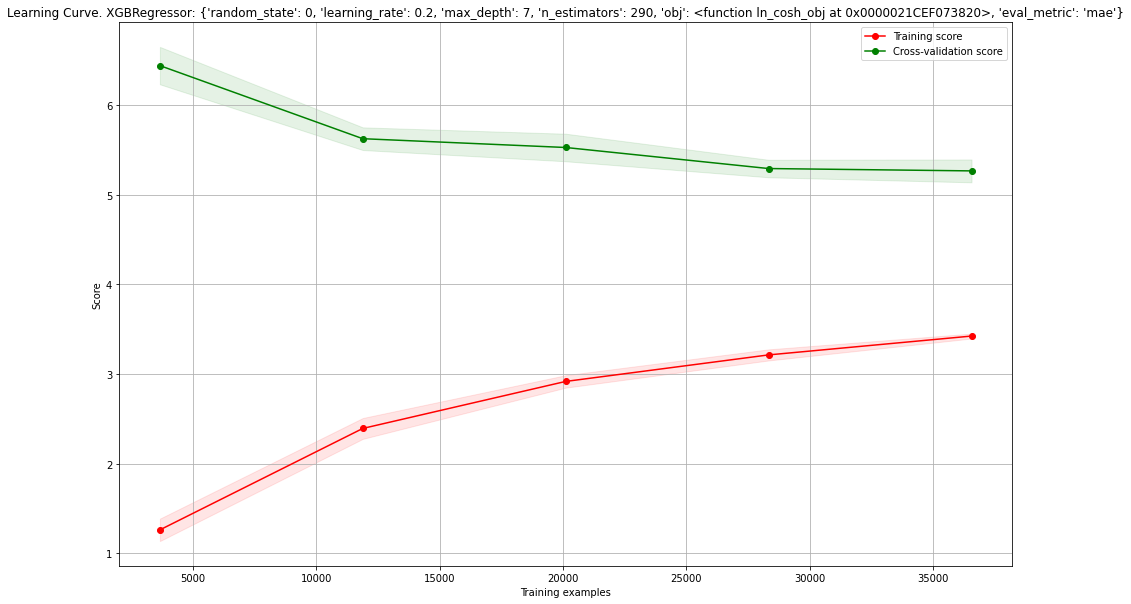

In [29]:
model_params = {
    'random_state': 0,
    'learning_rate': 0.2,
    'max_depth': int(trials.best_trial['misc']['vals']['x_max_depth'][0]), # 7
    'n_estimators': int(trials.best_trial['misc']['vals']['x_reg_n_estimators'][0]), # 237
    'obj': ln_cosh_obj,
    'eval_metric': 'mae',
}

run_cv_model(xgb.XGBRegressor, model_params, X_train, y_log_tain, cv=5)

In [30]:
model = xgb.XGBRegressor(**model_params)
model.fit(X_train, y_log_tain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=290, n_jobs=32, num_parallel_tree=1,
             obj=<function ln_cosh_obj at 0x0000021CEF073820>, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Wall time: 17.8 s


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

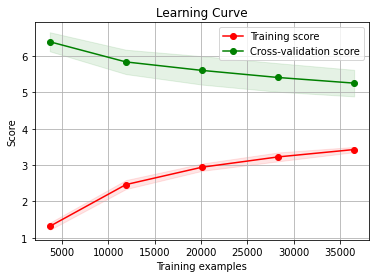

In [31]:
%time plot_learning_curve(model, X_train, y_log_tain, cv=5, random_state=0, n_jobs=8, shuffle=True, scoring=my_scorer);

In [32]:
print("predict")
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

print("save file")
test['price'] = y_pred
test[['id', 'price']].to_csv('model_dummy.csv', index=False) 

predict
save file


D:\venv\pml8\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
